## 实战项目：图像标注

使用已被训练的模型为测试数据集中的图像生成标注。

你可以通过点击以下链接导航到该notebook：
- [Step 1](#step1): 获取测试数据集的数据加载器
- [Step 2](#step2): 加载训练模型
- [Step 3](#step3): 完成取样器
- [Step 4](#step4): 清理标注
- [Step 5](#step5): 生成预测！

<a id='step1'></a>
## Step 1: 获取测试数据集的数据加载器

在运行下面的代码单元格之前，请在`transform_test`中定义要用于预处理测试图像的转换。

In [1]:
import sys
sys.path.append('/opt/cocoapi/PythonAPI')
from pycocotools.coco import COCO
from data_loader import get_loader
from torchvision import transforms
transform_test = transforms.Compose([transforms.Resize((224,224)),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))])
data_loader = get_loader(transform=transform_test,    
                         mode='test')

Vocabulary successfully loaded from vocab.pkl file!


在应用预处理之前，运行下面的代码单元格，将示例测试图像可视化。

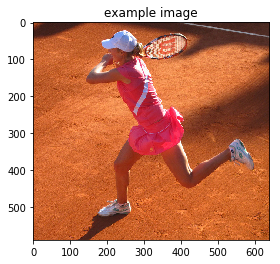

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
orig_image, image = next(iter(data_loader))
plt.imshow(np.squeeze(orig_image))
plt.title('example image')
plt.show()

<a id='step2'></a>
## Step 2: 加载训练模型

在下一个代码单元格中，我们定义了一个`device`，你将使用它将PyTorch张量移动到GPU中（如果CUDA可用的话）。在继续下一步之前，请运行此代码单元格。

In [3]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

在运行下面的代码单元格之前，请完成以下任务。

### 任务 #1

加载已被训练的编码器和解码器。

### 任务＃2

插入嵌入尺寸和解码器隐藏层的尺寸.

In [4]:
# Watch for any changes in model.py, and re-load it automatically.
% load_ext autoreload
% autoreload 2

import os
import torch
from model import EncoderCNN, DecoderRNN

# TODO #2: Specify the saved models to load.
encoder_file = 'encoder-3.pkl'
decoder_file = 'decoder-3.pkl'

# TODO #3: Select appropriate values for the Python variables below.
embed_size = 512
hidden_size =512

# The size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)

# Initialize the encoder and decoder, and set each to inference mode.
encoder = EncoderCNN(embed_size)
encoder.eval()
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)
decoder.eval()

# Load the trained weights.
encoder.load_state_dict(torch.load(os.path.join('./models', encoder_file)))
decoder.load_state_dict(torch.load(os.path.join('./models', decoder_file)))

# Move models to GPU if CUDA is available.
encoder.to(device)
decoder.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:03<00:00, 25977643.09it/s]
/opt/conda/lib/python3.6/site-packages/torch/nn/modules/rnn.py:38: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


DecoderRNN(
  (caption_embeddings): Embedding(9955, 512)
  (lstm): LSTM(512, 512, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.2)
  (fc): Linear(in_features=512, out_features=9955, bias=True)
)

<a id='step3'></a>
## Step 3: 完成取样器

在执行下一个代码单元格之前，必须要编写**model.py**中的`DecoderRNN`类的`sample` 方法。该方法应接收包含对应于单个图像的嵌入输入特征的PyTorch张量`features`作为输入。

作为输出，它应该返回一个Python列表`output`，用于指示预测的语句。 `output[i]`是一个非负整数，用于标识句子中预测的第`i`个标记。你可以通过检查`data_loader.dataset.vocab.word2idx` 或 `data_loader.dataset.vocab.idx2word`来探索整数和标记之间的对应关系。

实现`sample`方法后，运行下面的代码单元格。如果单元格返回一个断言错误，请在继续操作之前按照说明修改代码，但请勿修改下面单元格中的代码。

In [5]:
# Move image Pytorch Tensor to GPU if CUDA is available.
image = image.to(device)

# Obtain the embedded image features.
features = encoder(image).unsqueeze(1)

# Pass the embedded image features through the model to get a predicted caption.
output = decoder.sample(features)
print('example output:', output)

assert (type(output)==list), "Output needs to be a Python list" 
assert all([type(x)==int for x in output]), "Output should be a list of integers." 
assert all([x in data_loader.dataset.vocab.idx2word for x in output]), "Each entry in the output needs to correspond to an integer that indicates a token in the vocabulary."

example output: [0, 3, 91, 130, 355, 1492, 39, 3, 1492, 763, 18, 1, 1, 1, 1, 1, 1, 1, 1, 1]


<a id='step4'></a>
## Step 4: 清理标注

在下面的代码单元格中，完成`clean_sentence`函数。它应把一个整数列表（对应于**Step 3**中的变量`output`）作为输入并返回相应的预测语句（作为单个Python字符串）。

In [6]:
def clean_sentence(output):
    sentence = ''
    for word in [data_loader.dataset.vocab.idx2word.get(x) for x in output]:
        
        if word == '<end>':
            break
        if word != '<start>' and word != '.' :
            sentence += ' ' + word
        if word == '.':
            sentence += word 
    sentence = sentence[1].upper() + sentence[2:]
    return sentence

完成上面的`clean_sentence`函数后，运行下面的代码单元格。如果单元格返回一个断言错误，请在继续操作之前按照说明修改代码。

In [7]:
sentence = clean_sentence(output)
print('example sentence:', sentence)

assert type(sentence)==str, 'Sentence needs to be a Python string!'

example sentence: A woman is playing tennis on a tennis court.


<a id='step5'></a>
## Step 5: 生成预测！

在下面的代码单元格中，我们编写了一个函数(`get_prediction`，你可以使用该函数遍历测试数据集中的图像并输出模型的预测描述。

In [8]:
def get_prediction():
    orig_image, image = next(iter(data_loader))
    plt.imshow(np.squeeze(orig_image))
    plt.title('Sample Image')
    plt.show()
    image = image.to(device)
    features = encoder(image).unsqueeze(1)
    output = decoder.sample(features)    
    sentence = clean_sentence(output)
    print(sentence)

运行下面的代码单元格，测试此函数的运行方式。如果你愿意的话，可以尝试多次运行

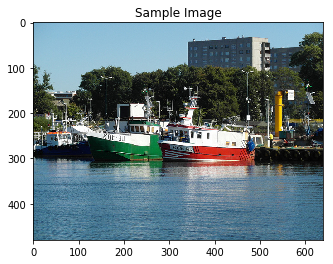

A boat is sailing in the water.


In [14]:
get_prediction()

作为此项目的最后一项任务，你要做的是遍历图像，直到找到四个感兴趣的图像标注对：
- 其中，有两个应该包括图像标注对，且该标注对会突出显示模型表现良好的实例。
- 另外两个应突出显示图像标注对，且该标注对会突出显示模型效果不佳的实例。

使用下面的四个代码单元格来完成此任务。

### 该模型表现良好！

使用接下来的两个代码单元格来遍历所有标注。如果遇到两张图像有相对准确的标注，请保存该notebook。

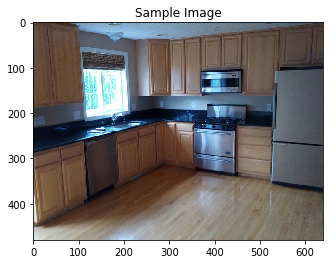

A kitchen with a stove and a refrigerator


In [17]:
get_prediction()

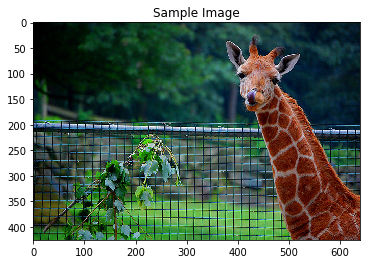

A giraffe standing in a field with a fence


In [22]:
get_prediction()

### 该模型表现不佳......

使用接下来的两个代码单元格来遍历所有标注。如果遇到两个图像有相对不准确的标注，请保存该notebook。

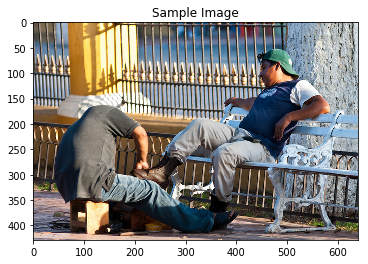

A man and a woman sitting on a bench


In [34]:
get_prediction()

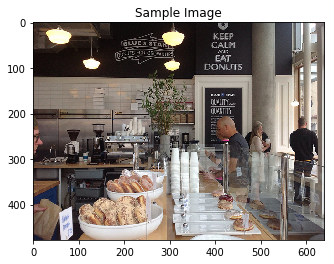

A woman is standing in front of a table with a cake.


In [48]:
get_prediction()